In [1]:
!pip install gdown faiss-cpu
!gdown https://drive.google.com/u/0/uc?id=1nMQibdolybOL1GWKB1OYxqU9KtEnrhB1&export=download
!unzip setup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 4.2 MB/s 
Downloading...
From: https://drive.google.com/u/0/uc?id=1nMQibdolybOL1GWKB1OYxqU9KtEnrhB1
To: /content/setup.zip
100% 72.4M/72.4M [00:02<00:00, 35.8MB/s]
Archive:  setup.zip
   creating: setup/
  inflating: setup/.DS_Store         
  inflating: __MACOSX/setup/._.DS_Store  
   creating: setup/twitch/
  inflating: setup/twitch/.DS_Store  
  inflating: __MACOSX/setup/twitch/._.DS_Store  
   creating: setup/twitch/N:100000_K:10_seed:0/
   creating: setup/twitch/.ipynb_checkpoints/
   creating: setup/twitch/N:100000_K:10_seed:0/data/
   creating: setup/twitch/N:100000_K:10_seed:0/data/test/
  inflating: setup/twitch/N:100000_K:10_seed:0/data/prod_emb.npy  
   creating: setup/twitch/N:100000_K:10_seed:0/data/train/
  inflating: setup/twitch/N:100000_K:10_seed:0/data/index  
   creating: setup/twitch/N:100000_K:10_seed:0/data/val/
  inflat

In [2]:
import pandas as pd
import numpy as np
from scipy import sparse
import os

import scipy.sparse.linalg as sp_l
import faiss
import torch 
from torch import nn, optim
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def load_tensor_spmx_dataset(path, split = 'train'):
    load_dir = os.path.join(path, split)
    contexts = torch.load(os.path.join(load_dir, 'contexts.pt'))
    rewards = sparse.load_npz(os.path.join(load_dir, 'rewards.npz'))
    return contexts, rewards

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

print('Loading the different splits')
exp_folder_path = 'setup/twitch/N:100000_K:10_seed:0'
data_folder = os.path.join(exp_folder_path, 'data')

contexts_train, rewards_train = load_tensor_spmx_dataset(data_folder, split = 'train')
contexts_val, rewards_val = load_tensor_spmx_dataset(data_folder, split = 'val')
contexts_test, rewards_test = load_tensor_spmx_dataset(data_folder, split = 'test')

print('Loading the embeddings')
prod_emb = np.load(os.path.join(data_folder, 'prod_emb.npy'))
P = prod_emb.shape[0]
print('number of products is %d'%P)

print('Loading the index')
index = faiss.read_index(os.path.join(data_folder, 'index'))

Loading the different splits
Loading the embeddings
number of products is 790100
Loading the index


In [3]:
class policy_model(torch.nn.Module):
    def __init__(self, emb):
        super(policy_model, self).__init__()
        self.emb = torch.Tensor(emb.T)
        self.K, _ = self.emb.shape
        self.theta = torch.nn.Parameter(0.005 * torch.randn(self.K, self.K))
        self.log_sigma = torch.nn.Parameter(torch.zeros(1))

    def forward(self, x):
        x_transformed = torch.matmul(x, self.theta)
        log_unnormalized = torch.matmul(x_transformed, self.emb)
        return nn.functional.softmax(log_unnormalized, dim = -1), log_unnormalized
    
    def sample(self, x, n_samples = 1):
        x_transformed = torch.matmul(x, self.theta)
        log_unnormalized = torch.matmul(x_transformed, self.emb)
        scores = torch.exp(log_unnormalized - log_unnormalized.max())
        actions = torch.multinomial(scores, n_samples, replacement=True)
        return actions
    
    def argmax(self, x):
        x_transformed = torch.matmul(x, self.theta)
        log_unnormalized = torch.matmul(x_transformed, self.emb)
        return torch.argmax(log_unnormalized, dim = 1, keepdim = True)
    
    def Xtransformed(self, x):
        x_transformed = torch.matmul(x, self.theta)
        return x_transformed

### Training/Testing Routine

We define the code to test out the policies once trained.

In [4]:
def test_policy(policy, index, contexts, rewards, bsize):
    
    greed_reward_index, greed_reward = 0., 0.
    N_test = contexts.size(0)
    idxlist = np.arange(N_test)
    
    for bnum, st_idx in tqdm(enumerate(range(0, N_test, bsize))):
            end_idx = min(st_idx + bsize, N_test)
            indices = idxlist[st_idx:end_idx]
            len_indices = len(indices)
            help_broadcast = np.arange(len_indices)
            
            r = rewards[indices]
            c = contexts[indices]
            
            _, top_actions_index = index.search(policy.Xtransformed(c).cpu().detach().numpy(), k = 1)
            top_rewards_index = rewards[indices[:,np.newaxis], top_actions_index].A
            
            top_actions = policy.argmax(c).cpu().numpy()
            top_rewards = rewards[indices].A[help_broadcast[:,np.newaxis], top_actions]
            
            
            r_a_index = top_rewards_index.sum()
            r_a = top_rewards.sum()

            greed_reward_index += r_a_index/N_test
            greed_reward += r_a/N_test
                
    return greed_reward_index, greed_reward

We also define the training routine boiler-plate that every algorithm will use.

In [5]:
def training_routine(algorithm_loss, pi, index, n_samples, P, trunc_at, eps, contexts, rewards, epochs, bsize, lr, reg, val_contexts, val_rewards) :
    
    optimizer = torch.optim.Adam(pi.parameters(), lr=lr, weight_decay=reg)
    N_train = contexts.size(0)
    idxlist = np.arange(N_train)
    proposal_probs = torch.ones(bsize, P) * eps/P
    
    train_m_rewards = []
    val_max, val_max_index = [0.]*epochs, [0.]*epochs
    
    true_duration = 0.
    
    for i in range(epochs):
        print("epoch number %d"%i)
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in tqdm(enumerate(range(0, N_train, bsize))):
            base_time = time.time()
            
            end_idx = min(st_idx + bsize, N_train)
            indices = idxlist[st_idx:end_idx]
            indices_len = len(indices)
            
            X = contexts[indices]

            loss = algorithm_loss(pi, contexts, rewards, indices, index, n_samples, proposal_probs)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            true_duration += time.time() - base_time
            
            _, top_actions = index.search(pi.Xtransformed(X).detach().numpy(), k = 1)
            top_rewards = rewards[indices[:,np.newaxis], top_actions].A
            r_a = top_rewards.mean()
            train_m_rewards.append(r_a)
            
        print('Computing metrics on val')
        max_perf_index, max_perf = test_policy(pi, index, val_contexts, val_rewards, 512)
        val_max_index[i], val_max[i] = max_perf_index, max_perf
        print('Argmax reward on the validation : INDEX %.4f, TRUE %.4f'%(max_perf_index, max_perf))
        
    return train_m_rewards, val_max_index, val_max, true_duration


## Reinforce

In large scale recommendation problems, we usually deal with a considerable amount of observations making stochastic gradient descent and its variants suitable for such application. For a single observation $x_i$, we are interested in the gradient of $\hat{R}_i(\pi_\theta) = \mathbf{\mathbb{E}}_{a \sim \pi_\theta(.|x_i)}[\hat{r}(a, x_i)]$ which can be derived using the log trick giving the following formula:

\begin{align}
\label{reinforce}
\nabla_\theta \hat{R}_i(\pi_\theta) = \mathbf{\mathbb{E}}_{a \sim \pi_\theta(.|x_i)}[\hat{r}(a, x_i)\nabla_\theta \log \pi_\theta(a|x_i)].
\end{align}


In [6]:
def reinforce_loss(pi, contexts, rewards, indices, index, n_samples, proposal_probs):
    
    X = contexts[indices]
    indices_len = len(indices)
    probs, _ = pi(X)
    with torch.no_grad():
        actions = torch.multinomial(probs, n_samples, replacement=True)
        r_a = torch.Tensor(rewards[indices[:,np.newaxis], actions].A)

    help_broadcast = np.arange(indices_len)[:,np.newaxis]
    return -torch.mean(r_a * torch.log(probs[help_broadcast, actions]))

This gradient can be computed exactly as an expectation over a discrete distribution, our current policy $\pi_\theta$, when the action space is of small size. Once the size of the catalog $P$ is in the order of millions, an exact gradient update becomes a bottleneck for the optimization process because of the complexity of the following computations:

**1 - Computing $\nabla_\theta \log \pi_\theta(.|x_i)$**: 

We need to deal with the normalizing constant $Z_\theta(x_i)$ present in the computation of $\nabla_\theta \log \pi_\theta(.|x_i)$. Indeed, $Z_\theta(x_i)$ is a sum over all the action space and its computation needs to be avoided if we hope to reduce the complexity of the gradient update.

**2 - Computing the expectation**:

The expectation is a sum over all the action space and is obviously computed in $\mathcal{O}(P)$. To avoid this expensive sum, we can resort to sampling from $\pi_\theta$ to approximate the gradient. This allows us to obtain the Reinforce estimator, an unbiased estimator of the expectation but does not change the complexity of the method which stays linear in the catalog size. Indeed, sampling needs the computation of $Z_\theta(x_i)$ or can be done with the gumbel trick which both scale in $\mathcal{O}(P)$. To lower the time complexity, we need to avoid sampling directly from $\pi_\theta$ and use Monte Carlo techniques instead such as importance sampling/rejection sampling with carefully chosen proposals to achieve fast sampling and accurate gradient approximation.


# Accelerating Reinforce

As pointed out in the previous section, we need a workaround to deal with the presence of the normalizing constant in the gradient. For a fixed observations $x_i$, we can push further the computation of $\nabla_\theta \log \pi_\theta(a|x_i)$ to obtain a quantity that does not involve $Z_\theta(x_i)$. Indeed, we have for a fixed action $a$:

\begin{align*}
\nabla_\theta \log \pi_\theta(a|x_i) &= \nabla_\theta f_\theta(a, x_i) - \nabla_\theta \log Z_\theta(x_i) \\
&= \nabla_\theta f_\theta(a, x_i) - \frac{\nabla_\theta Z_\theta(x_i)}{Z_\theta(x_i)} \\
&= \nabla_\theta f_\theta(a, x_i) - \sum_b \pi_\theta(b|x_i) \nabla_\theta f_\theta(b, x_i) \\
&= \nabla_\theta f_\theta(a, x_i) -  \mathbf{\mathbb{E}}_{b \sim \pi_\theta(.|x_i)}[\nabla_\theta f_\theta(b, x_i)]
\end{align*}


Injecting the above expression of $\nabla_\theta \log \pi_\theta(a|x_i)$ into the reinforce gradient leads us to the following covariance gradient:

\begin{align}
\nabla_\theta \hat{R}_i(\pi_\theta) = \mathbf{Cov}_{a \sim \pi_\theta(.|x_i)}[\hat{r}(a, x_i),  \nabla_\theta f_\theta(a, x_i)] \label{cov_grad}
\end{align}


with 
\begin{align*}
    \mathbf{Cov}[A, \boldsymbol{B}] &= \mathbf{\mathbb{E}}[A.\boldsymbol{B}] - \mathbf{\mathbb{E}}[A].\mathbf{\mathbb{E}}[\boldsymbol{B}] \\
    &= \mathbf{\mathbb{E}}[(A - \mathbf{\mathbb{E}}[A] ).(\boldsymbol{B} - \mathbf{\mathbb{E}}[\boldsymbol{B}])] 
\end{align*}

Now that we got rid of the normalizing constant inside the gradient, we need to approximate the expectation with Self Normalized Importance Sampling:

$$\mathbf{\mathbb{E}}_{\pi_\theta(.|x_i)}[g(a)] \approx \sum_{s = 1}^S \bar{\omega}_s g(a_s)$$
 

with $a_s \sim q \quad \forall s$, $\omega_s = \frac{\exp \{f(a_s, x_i)\}}{q(a_s)}$ and $\bar{\omega}_s = \frac{\omega_s}{\sum_{s' = 1}^S \omega_{s'}}$.

### SNIPS - Uniform Proposal

we use the uniform proposal to approximate the gradient :

$$q(a|x) = \frac{1}{P}$$ with P the catalg size.

In [7]:
def uniform_loss(pi, contexts, rewards, indices, index, n_samples, proposal_probs):
    
    X = contexts[indices]
    len_indices = len(indices)
    x_transformed = torch.matmul(X, pi.theta)
    a_samples = torch.randint(P, [len_indices, n_samples])
    a_embs = pi.emb[:, a_samples]

    log_p_tilde = torch.einsum('ij,jik->ik', x_transformed, a_embs)
    with torch.no_grad():
        ws = torch.nn.functional.softmax(log_p_tilde, dim=-1) # SNIPS

    r_a = torch.Tensor(rewards[indices[:,np.newaxis], a_samples].A)

    mean_log_p_tilde, mean_rewards = torch.sum(ws * log_p_tilde, dim=-1, keepdim=True), torch.sum(ws * r_a, dim=-1, keepdim=True)
    
    return - torch.mean(torch.sum(ws * (log_p_tilde - mean_log_p_tilde) * (r_a - mean_rewards), dim=-1))

## SNIPS - Mixture Proposal

We use a proposal that uses the MIPS index in training time as well, which is a mixture between a uniform (to cover the first training phase) and the head of the distribution (covers the late training phases when the policy concentrates on the good items).

By constructing the head of the distribution (K top actions, with K a hyperparameter) $\alpha_K(x_i)= {\rm argsort}(h_{\theta}(x_i)^T\beta)_{1:K}$ with the help of MIPS, we define :

$$
    q_{K, \epsilon}(a|x_i)= 
\begin{cases}
    \frac{\epsilon}{P} + (1-\epsilon)\kappa(a|x_i),              & \text{if } a \in \alpha_K(x_i) \\
    \frac{\epsilon}{P},& \text{otherwise }.
\end{cases}
$$

Where $\epsilon$ is a parameter that controls the mixture and 
$$
\kappa(a|x_i) = \frac{\exp(h_{\theta}(x_i)^T\beta_a)}{\sum_{a' \in \alpha_K(x_i)}  \exp(h_{\theta}(x_i)^T\beta_{a'})}1[a \in \alpha_K(x_i)].
$$

Note that $\epsilon = 1.$ retrieves the uniform proposal. 

In [8]:
def mixture_loss(pi, contexts, rewards, indices, index, n_samples,proposal_probs):
    
    len_indices = len(indices)
    help_broadcast = np.arange(len_indices)[:,np.newaxis]

    X = contexts[indices]
    x_transformed = torch.matmul(X, pi.theta)

    query = x_transformed.cpu().detach().numpy()
    topK_scores, topK_indices = index.search(query, k = trunc_at)


    topK_indices, topK_scores = torch.tensor(topK_indices), torch.tensor(topK_scores)
    topK_probs = torch.nn.functional.softmax(topK_scores, dim=-1)

    proposal_probs[help_broadcast, topK_indices] += (1. - eps) * topK_probs

    uni_n_samples = int(n_samples * eps)
    a_samples_uni = torch.randint(P, [len_indices, uni_n_samples])
    a_samples_topK = topK_indices[help_broadcast, torch.multinomial(topK_probs, n_samples - uni_n_samples, replacement=True)]

    a_samples = torch.cat([a_samples_uni, a_samples_topK], dim=1)

    a_embs = pi.emb[:, a_samples]
    log_p_tilde = torch.einsum('ij,jik->ik', x_transformed, a_embs)

    # SNIPS
    with torch.no_grad():
        log_ws_tilde = log_p_tilde - torch.log(proposal_probs[help_broadcast, a_samples])
        ws = torch.nn.functional.softmax(log_ws_tilde, dim=-1)

    r_a = torch.Tensor(rewards[indices[:,np.newaxis], a_samples].A)
    mean_log_p_tilde, mean_rewards = torch.sum(ws * log_p_tilde, dim=-1, keepdim=True), torch.sum(ws * r_a, dim=-1, keepdim=True)
    
    proposal_probs[help_broadcast, topK_indices] = eps/P
    
    return - torch.mean(torch.sum(ws * (log_p_tilde - mean_log_p_tilde) * (r_a - mean_rewards), dim=-1))


## Experiments :

In [9]:
epochs = 1
bsize = 32
reg = 1e-10

lr = 1e-4
n_samples = 1000
eps = 0.8
trunc_at = 256

### Training the policies

In [10]:
# Reinforce
policy_reinforce = policy_model(prod_emb)
train_r, val_r, _, duration_r = training_routine(reinforce_loss, policy_reinforce, index, n_samples, P, trunc_at, eps, 
                                                 contexts_train, rewards_train, epochs, bsize, lr, reg, contexts_val, rewards_val)

epoch number 0


2500it [11:48,  3.53it/s]


Computing metrics on val


20it [00:39,  1.98s/it]

Argmax reward on the validation : INDEX 0.1922, TRUE 0.2264


In [11]:
# Uniform proposal
policy_uniform = policy_model(prod_emb)
train_u, val_u, _, duration_u = training_routine(uniform_loss, policy_uniform, index, n_samples, P, trunc_at, eps, 
                                                              contexts_train, rewards_train, epochs, bsize, lr, reg, contexts_val, rewards_val)

epoch number 0


2500it [00:47, 52.83it/s]


Computing metrics on val


20it [00:36,  1.84s/it]

Argmax reward on the validation : INDEX 0.2174, TRUE 0.2266


In [12]:
# Mixture proposal
policy_mixture = policy_model(prod_emb)
train_m, _, val_m, duration_m = training_routine(mixture_loss, policy_mixture, index, n_samples, P, trunc_at, eps, 
                                                 contexts_train, rewards_train, epochs, bsize, lr, reg, contexts_val, rewards_val)

epoch number 0


2500it [01:14, 33.48it/s]


Computing metrics on val


20it [00:36,  1.84s/it]

Argmax reward on the validation : INDEX 0.2246, TRUE 0.2252


### Relative speed-up :

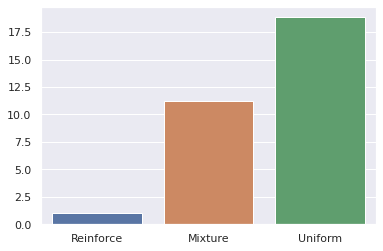

In [13]:
x = ['Reinforce', 'Mixture', 'Uniform']
y = [1., duration_r/duration_m, duration_r/duration_u]

sns.barplot(x = x, y = y)
plt.show()

## Performance:

In [15]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

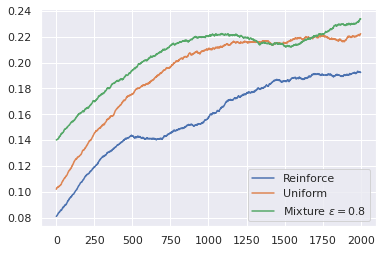

In [19]:
plt.plot(moving_average(train_r, 300), label = 'Reinforce')
plt.plot(moving_average(train_u, 300), label = 'Uniform')
plt.plot(moving_average(train_m, 300), label = 'Mixture $\epsilon = 0.8$')

plt.legend()
plt.show()

To compare the performance of all the methods, one needs to run extensive experiments on larger portions of the datasets for longer epochs. This can't be achieved in a tutorial so we invite the most curious to dive into the paper : [Fast Offline Policy Optimization for Large Scale Recommendation](https://arxiv.org/abs/2208.05327)